In [26]:
from typing import TypedDict

class State(TypedDict):
    missing_answer: str
    summary_answer: str
    booking_reference: str
    si_data: dict
    next: str

In [27]:
# !pip install langchain-community 
# !pip install langchain-google-genai

In [28]:
from dotenv import load_dotenv

load_dotenv()

True

In [29]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

In [42]:
workflow = StateGraph(State)

In [63]:
def get_bkg_node(state: State):
    return ''

def get_si_node(state: State):
    return ''

def check_missing_data_node(state: State):
    return ''

def generate_intake_report_node(state: State):
    return ''

In [47]:
# Add nodes
workflow.add_node("get_bkg", get_bkg_node)
workflow.add_node("get_si", get_si_node)
workflow.add_node("check_missing_data", check_missing_data_node)
workflow.add_node("generate_intake_report", generate_intake_report_node)

        # Add edges
workflow.set_entry_point("get_bkg")
workflow.add_edge("get_bkg", "get_si")
workflow.add_edge("get_si", "check_missing_data")
workflow.add_edge("check_missing_data", "generate_intake_report")
workflow.add_edge("generate_intake_report", END)

In [48]:
graph = workflow.compile()

In [51]:
!python3 -m pip install -U --no-cache-dir  \
            --config-settings="--global-option=build_ext" \
            --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
            --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
            pygraphviz

I0000 00:00:1727750975.831839 7833948 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp312-cp312-macosx_14_0_arm64.whl size=92380 sha256=252d45f57d31cf0230942cc4b164104002e2d0d3dd6b3e9212f613ca8a93be49
  Stored in directory: /private/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/pip-ephem-wheel-cache-cfownrn0/wheels/e1/2f/c3/0f7719eda975973b474b79b98e1208e635565c1e4dac777ac8
Successfully built pygraphviz


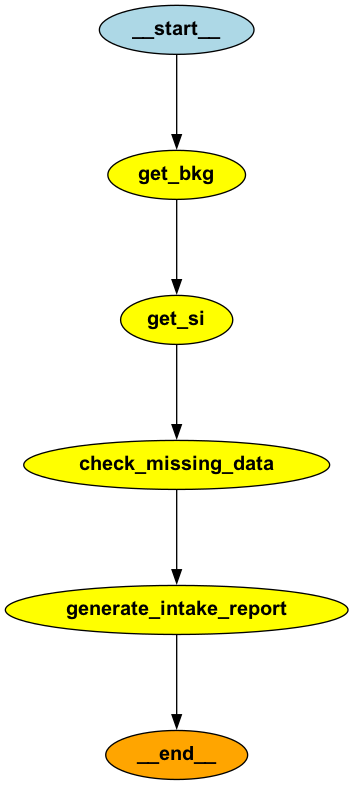

In [52]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [57]:
from si_validation_story.graphs.nodes.si_intake import si_intake_state, get_bkg, get_si, check_missing_data, generate_intake_report
from langgraph.graph import StateGraph, END

class SIIntake:
    def __init__(self):
        self.get_bkg_node = get_bkg.GetBKG()
        self.get_si_node = get_si.GetSI()
        self.check_missing_data_node = check_missing_data.CheckMissingData()
        self.generate_intake_report_node = generate_intake_report.GenerateIntakeReport()
        self.graph = self.generate_graph()

    def generate_graph(self):
        workflow = StateGraph(si_intake_state.State)

        # Add nodes
        workflow.add_node("get_bkg", self.get_bkg_node)
        workflow.add_node("get_si", self.get_si_node)
        workflow.add_node("check_missing_data", self.check_missing_data_node)
        workflow.add_node("generate_intake_report", self.generate_intake_report_node)

        # Add edges
        workflow.set_entry_point("get_bkg")
        workflow.add_edge("get_bkg", "get_si")
        workflow.add_edge("get_si", "check_missing_data")
        workflow.add_edge("check_missing_data", "generate_intake_report")
        workflow.add_edge("generate_intake_report", END)

        self.graph = workflow.compile()
    
    def invoke(self):
        initial_state = si_intake_state.State()
        return self.graph.invoke(initial_state)

In [58]:
from si_validation_story.layouts.pages._page_templates import SearchPage, BLDraftPage, SummaryPage

In [59]:
# summary_graph = SIIntake()
#summary_page = SummaryPage(chapter_name="Ch1: Shipping Instrunction Intake", graph=summary_graph)

In [61]:
check_missing_data.CheckMissingData()

In [64]:
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

gpt_4o_mini = ChatOpenAI(temperature=0, 
                    model_name="gpt-4o-mini",
                    streaming=True,              
                    callbacks=[StreamingStdOutCallbackHandler()]
                    )

In [68]:
state = State

In [78]:
booking_reference = 'CHERRY202409072244'

In [79]:
from si_validation_story.graphs.nodes.common.tools import MongoDB

class GetSI:
    def __init__(self):
        self.collection_name = "si"
        self.db = MongoDB()
        self.collection = self.db.load_collection(self.collection_name)
    
    def __call__(self, booking_reference) -> State:
        si_data = self.collection.find_one_booking_reference(booking_reference)
        return si_data
        # state["next"] = "check_missing_data"
        # return state


In [92]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set up MongoDB connection using environment variables
MONGO_URI = os.getenv("MONGODB_URI")
DB_NAME = os.getenv("MONGODB_DB_NAME")
COLLECTION_NAME = "si"  # Collection storing shipping instructions

# Create MongoDB client and connect to the specific database and collection
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

def fetch_shipping_instruction(booking_reference):
    """
    Fetch the shipping instruction from MongoDB based on the booking reference.
    """
    return collection.find_one({'bookingReference': booking_reference})


In [94]:
si_data = fetch_shipping_instruction(booking_reference)

In [95]:
state = {}
state['si_data'] = si_data

In [100]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser

In [101]:
llm = gpt_4o_mini

In [109]:
check_missing_prompt="""
Analyze the following Shipping Instruction (SI) data, focusing on missing or incomplete information in key sections excluding the ‘Additional Information’ field. Assess each section for completeness: ‘Voyage & Route Details,’ ‘Payment & Documentation,’ ‘Party Details,’ ‘Shipping Information,’ ‘Containers,’ and ‘Total Shipment.’ For missing or incomplete details, return a summary highlighting which data is missing or invalid. Provide a concise and structured output similar to the example below.

Data:
{si_data}

Example Output:

This is the summarized report on SI cherry202409072244:

	1. VESSEL VOYAGE BOUND: OK (APL TEMASEK, 2024581E)
	2. PARTIES
		- SHIPPER: OK
		- CONSIGNEE: OK
		- NOTIFY PARTY: OK
	3. PLACE OF RECEIPT: OK
		- PORT OF LOADING: OK
		- PORT OF DISCHARGING: OK
		- PLACE OF DELIVERY: OK
	4. DESCRIPTIONS OF GOODS
		- CONTAINER/SEAL NO: OK
		- CONTAINER UNIT: OK
		- MARKS AND NUMBERS: OK
		- NUMBER AND PACKAGE TYPE: OK
		- COMMODITY: OK (POWER TRANSFORMERS)
		- SHIPPING TERMS: OK (CIF)
		- FREIGHT TERMS: OK (COLLECT)
    5. ...
"""

In [ ]:
# Step 0 : Import Libraries
import os
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List, Dict, Any
from langchain_core.output_parsers import StrOutputParser
import asyncio
from web_search import WebSearch # web_search module from other file "web_search.py"

# Step 1: Load documents from web or local sources (PDFs and URLs)
def load_documents(sources: List[str]) -> List:
    """
    Load documents from the provided sources (PDFs or URLs).
    """
    docs = []
    for source in sources:
        try:
            if source.startswith('http'):
                print(f"Loading documents from URL: {source}")
                loader = WebBaseLoader(source)
            elif source.endswith('.pdf'):
                print(f"Loading documents from PDF: {source}")
                loader = PyPDFLoader(source)
            else:
                print(f"Unsupported source type: {source}")
                continue
            docs.extend(loader.load())
        except Exception as e:
            print(f"Error loading from {source}: {e}")
    return docs

# Step 2: Create the FAISS vector store
def create_vectorstore(documents):
    """
    Create and save the FAISS vector store for document retrieval.
    """
    embedding_model = OpenAIEmbeddings()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    split_docs = text_splitter.split_documents(documents)
    vectorstore = FAISS.from_documents(split_docs, embedding_model)
    vectorstore.save_local("faiss_index")
    print("Vector store created and saved locally at 'faiss_index'.")
    return vectorstore

# Step 3: Load existing vectorstore or create a new one
def load_vectorstore(sources: List[str]):
    """
    Load the vector store from disk if it exists.
    If not, load documents and create a new vector store.
    """
    if os.path.exists("faiss_index/index.faiss"):
        print("Loading existing vector store from 'faiss_index'.")
        return FAISS.load_local("faiss_index", OpenAIEmbeddings(), allow_dangerous_deserialization=True)
    else:
        print("Vector store not found. Loading documents and creating a new vector store.")
        documents = load_documents(sources)
        return create_vectorstore(documents)

# Step 4: Web search for updated sanction lists
def perform_web_search(si_data: Dict[str, Any], include_urls: List[str], exclude_urls: List[str]) -> List[Dict[str, str]]:
    """
    Perform a web search to find updated sanction lists related to SI data.
    """
    search_results = []
    try:
        search_query = f"Find sanction list related to {si_data['SHIPPER']}, {si_data['CONSIGNEE']}, {si_data['NOTIFY']}, {si_data['HS_CODE']}, {si_data['CARGO_ITEM']}"
        search_engine = WebSearch()  # Initialize web search module
        search_results = search_engine.search(
            query=search_query, include_urls=include_urls, exclude_urls=exclude_urls
        )
    except Exception as e:
        print(f"Error performing web search: {e}")
    return search_results


# SI data validation function with web search
def validate_si_data(si_data: Dict[str, Any], compliance_docs: List[str], include_urls: List[str], exclude_urls: List[str]) -> List[str]:
    """
    Validate the SI data against CHERRY shipping line's company policy using both RAG and web search.
    """
    issues = []
    # Check with RAG (local compliance documents)
    sanctioned_keywords = ["sanctioned entity", "restricted item"]  # Example keywords
    for field in ['SHIPPER', 'CONSIGNEE', 'NOTIFY', 'HS_CODE', 'CARGO_ITEM']:
        if any(keyword in si_data.get(field, "").upper() for keyword in sanctioned_keywords):
            issues.append(f"{field} against the Sanctions of UN, EU or USA")

    # Check Description of Packages and Goods
    if "COMMERCIAL VALUE" in si_data.get('DESCRIPTION_OF_PACKAGES', "").upper():
        issues.append("Commercial value should not be included in cargo description.")
    
    # Check Embargo items at Port of Loading and Discharging
    embargo_items = ["restricted item", "embargoed goods"]  # Example keywords
    if any(item in si_data.get('DESCRIPTION_OF_PACKAGES', "").upper() for item in embargo_items):
        issues.append("Articles under the embargo at Port of Loading and Port of Discharging.")
    
    # Check Weight and Measurement notation
    if not validate_weight_and_measurement(si_data.get('CARGO_WEIGHT'), si_data.get('CARGO_MEASUREMENT')):
        issues.append("Cargo weight and measurement should be formatted to three decimal places.")
    
    # Check with web search (updated sanction lists)
    web_search_results = perform_web_search(si_data, include_urls, exclude_urls)
    if web_search_results:
        for result in web_search_results:
            if "sanction" in result['content'].lower():
                issues.append(f"Updated sanction found in web search: {result['title']} - {result['url']}")
    
    return issues

# Helper function for weight and measurement validation
def validate_weight_and_measurement(weight: str, measurement: str) -> bool:
    """
    Validate weight and measurement format to ensure three decimal places.
    """
    try:
        weight_valid = abs(float(weight) - round(float(weight), 3)) < 1e-9
        measurement_valid = abs(float(measurement) - round(float(measurement), 3)) < 1e-9
        return weight_valid and measurement_valid
    except (ValueError, TypeError):
        return False

# Step 5: Build Retrieval-Augmented Generation Pipeline
class RAGModel:
    def __init__(self, llm, sources: List[str], template, include_urls: List[str], exclude_urls: List[str]):
        self.vectorstore = load_vectorstore(sources)
        self.llm = llm
        self.prompt = PromptTemplate(template=template, input_variables=["si_data"])
        self.chain = self.prompt | self.llm | StrOutputParser()
        self.include_urls = include_urls
        self.exclude_urls = exclude_urls

    def retrieve_documents(self, question: str):
        """
        Retrieve relevant documents from the vectorstore based on the question (SI data).
        """
        retriever = self.vectorstore.as_retriever(search_kwargs={'k': 5})
        relevant_docs = retriever.get_relevant_documents(question)
        return relevant_docs

    def generate_response(self, si_data: str, retrieved_docs: list):
        """
        Generate a response using the retrieved documents and the language model.
        """
        context = "\n\n".join([doc.page_content for doc in retrieved_docs])
        question_with_context = f"{si_data}\n\nRelevant Documents:\n{context}"
        return self.chain.invoke({'si_data': question_with_context})

    def validate_and_generate(self, si_data: Dict[str, Any]):
        """
        Validate SI data and generate response for compliance validation using RAG and web search.
        """
        # Step 5-1: Validate SI data against policy using both RAG and web search
        issues = validate_si_data(si_data, self.vectorstore, self.include_urls, self.exclude_urls)
        if issues:
            print("Found the following issues in SI data:")
            for issue in issues:
                print(f"- {issue}")
            return {"issues": issues}
        
        # Step 5-2: Retrieve relevant compliance documents
        retrieved_docs = self.retrieve_documents(si_data['DESCRIPTION_OF_PACKAGES'])
        
        # Step 5-3: Generate response based on SI data and retrieved documents
        response = self.generate_response(si_data['DESCRIPTION_OF_PACKAGES'], retrieved_docs)
        print(response)
        return response


In [110]:
def check_missing(si_data):
    """
    Function to check for missing data in the shipping instruction using an LLM prompt.
    """
    prompt = PromptTemplate(
        template=check_missing_prompt,
        input_variables=["si_data"]
    )
    
    # Combine prompt with the LLM and parser
    chain = prompt | llm | StrOutputParser()
    
    try:
        # Synchronously invoke the LLM to check for missing data
        response = chain.invoke({"si_data": si_data})
        return response
    except Exception as e:
        raise RuntimeError(f"Error during checking missing data: {e}")

In [111]:
res = check_missing(si_data)

This is the summarized report on SI CHERRY202409072244:

	1. VESSEL VOYAGE BOUND: OK (APL TEMASEK, 2024581E)
	2. PARTIES
		- SHIPPER: OK
		- CONSIGNEE: OK
		- NOTIFY PARTY: OK
	3. PLACE OF RECEIPT: OK
		- PORT OF LOADING: OK
		- PORT OF DISCHARGING: OK
		- PLACE OF DELIVERY: OK
	4. DESCRIPTIONS OF GOODS
		- CONTAINER/SEAL NO: OK
		- CONTAINER UNIT: OK
		- MARKS AND NUMBERS: OK
		- NUMBER AND PACKAGE TYPE: OK
		- COMMODITY: OK (POWER TRANSFORMERS)
		- SHIPPING TERMS: OK (CIF)
		- FREIGHT TERMS: OK (COLLECT)
	5. PAYMENT & DOCUMENTATION
		- FREIGHT PAYMENT TERMS: OK (COLLECT)
		- FREIGHT PAYABLE AT: OK (ROTTERDAM, NETHERLANDS)
		- BILL OF LADING TYPE: OK (NEGOTIABLE)
		- NUMBER OF ORIGINAL BLS: OK (3)
		- NUMBER OF COPIES: OK (0)
	6. CONTAINERS
		- TOTAL CONTAINERS: OK (TWO (20 O/T X2) CONTAINERS ONLY)
		- TOTAL PACKAGES: OK (4)
		- PACKAGE TYPE: OK (CRATES)
		- TOTAL GROSS WEIGHT: OK (30000.0)
		- TOTAL MEASUREMENT: OK (60.0)
	7. OUT OF GAUGE DIMENSIONS: OK (In-Gauge)
	8. ADDITIONAL INFO

In [97]:
# def check_missing(state):
#     messages = [
#         SystemMessage(content=check_missing_prompt), 
#         HumanMessage(content=state['si_data'])
#     ]
#     response = gpt_4o_mini.invoke(messages)
#     return {"plan": response.content}

In [99]:
check_missing(state)

ValidationError: 2 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value={'_id': ObjectId('66e1562... special instructions'}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type
content.list[union[str,dict[any,any]]]
  Input should be a valid list [type=list_type, input_value={'_id': ObjectId('66e1562... special instructions'}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type

In [18]:
summary_graph

In [23]:
si_intake_state = si_data

In [62]:
# summary_graph.invoke()